<a href="https://colab.research.google.com/github/RiccardoPrestigiacomo-99/example/blob/main/tesinaMML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Astronomy and Machine Learning: a case study using images from a Cherenkov gamma-ray telescope**<br>
Riccardo Prestigiacomo - s283392@studenti.polito.it<br>

# Introduction

Astronomy, astrophysics, and particle physics all have made rapid progress as observational sciences in recent years. Much of this progress is due to the development of detector technology, coupled with a parallel development of analysis methods. Confronted with a daunting challenge of extracting a small number of interesting events from an overwhelming sea of background, both having very similar characteristics, physicists have become familiar with quite sophisticated multivariate techniques.
<p align="center">
  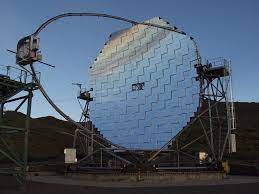
  <center>Ground-based gamma-ray telescope</center>
</p>
Ground-based gamma-ray telescopes are an example of experiments exploring a new research frontier, that are likely to benefit from the many multivariate data analysis techniques developed in recent years. In this case study, various multivariate techniques are applied to the same set of data. <br><br>
Ground-based atmospheric Cherenkov telescopes using the imaging techniques are a comparatively recent addition to the panopoly of instruments used by astrophysicists. They observe high-energy gamma rays, taking advantage of the radiation emitted by charged particles as they are produced abundantly inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of shower paramters.
One problem is that the number of observable Cherenkov photons for primary gammas of lower energy (below 100 GeV) becomes comparatively small, and correspondingly the problems of discrimination against background get enhanced. Optimal use of this information is critical for the success of this technique.

# Libraries

In [ ]:
#@title
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree
from sklearn.model_selection import GridSearchCV

# Dataset 

For our case study, we use the `MAGIC Gamma Telescope Data Set`. This data set contains generated data to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. <br> <br>
The data set was generated by a Monte Carlo program, Corsika, described in: D.Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers, Forschungszentrum Karlsruhe FZKA 6019 (1998) <br><br>
The task is to *discriminate stastically images generated by primary gammas* (signal, class label g) *from the images of hadronic showers* initiated by cosmic rays in the upper atmosphere (background, class label h) <br><br>
In the work presented we perform a general study, applying different multivariate classification methods to events described by 10 chosen image parameters. 

In [ ]:
#@title
# Getting started with MAGIC Gamma Telescope data set
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names

--2021-07-03 10:39:58--  http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477391 (1.4M) [application/x-httpd-php]
Saving to: ‘magic04.data.2’

magic04.data.2      100%[===================>]   1.41M  1.79MB/s    in 0.8s    

2021-07-03 10:40:00 (1.79 MB/s) - ‘magic04.data.2’ saved [1477391/1477391]

--2021-07-03 10:40:00--  http://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5400 (5.3K) [application/x-httpd-php]
Saving to: ‘magic04.names.2’

magic04.names.2     100%[===================>]   5.27K  --.-KB/s    in 0s 

## Attribute information

Let's start by showing the dataset's structure along with its variables.

In [ ]:
#@title
df = pd.read_csv('magic04.data',header=None)
columns = { 0: "fLength", 1: "fWidth", 2: "fSize", 3: "fConc", 4: "fConc1", 5: "fAsym", 6: "fM3Long", 7: "fM3Trans", 8: "fAlpha", 9: "fDist", 10: "class"} 
df.rename(columns=columns, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


We have 19020 samples, whose no value is missing.
In each row we have a numerical variable, and last we have a target binary variable: as this is a binary classification problem. <br>
Each event is characterized by the following **ten parameters**:

1.   `fLength`:  continuous  # major axis of ellipse [mm]
2.   `fWidth`:   continuous  # minor axis of ellipse [mm]
3.   `fSize`:    continuous  # 10-log of sum of content of all pixels [in #phot]
4.   `fConc`:    continuous  # ratio of sum of two highest pixels over fSize  [ratio]
5.   `fConc1`:   continuous  # ratio of highest pixel over fSize  [ratio]
6.   `fAsym`:    continuous  # distance from highest pixel to center, projected onto major axis [mm]
7.   `fM3Long`:  continuous  # 3rd root of third moment along major axis  [mm] 
8.  `fM3Trans`: continuous  # 3rd root of third moment along minor axis  [mm]
9.  `fAlpha`:   continuous  # angle of major axis with vector to origin [deg]
10.  `fDist`:    continuous  # distance from origin to center of ellipse [mm]
11.  `class`:    g,h         # gamma (signal), hadron (background)

The data consist of **two classes**: **gammas (signal)** and **hadrons (background)**.

## Dataset distribution


Events were generated at shower energies from 10 GeV up to about 30 TeV, and for zenith angles from zero to 20 degrees. The samples used by all methods are identical, and consist of **12332 gamma events** and **6888 hadron events**. <br>
The dataset is not well balanced: in fact 12332 events are gamma and 6888 hadron.

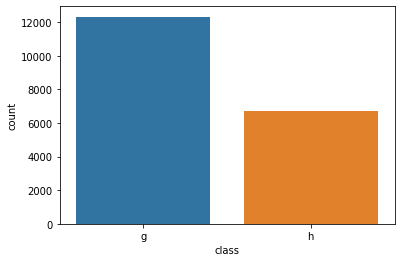

In [ ]:
#@title
sns.color_palette()
sns.countplot(x="class", data=df)

## Statistical overview

### Dataset description

For each attribute I analized the count, mean, standard deviation, minimum and maximum value and the quartiles.

In [ ]:
#@title
df.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


### Attribute domain

In [ ]:
#@title
df1 = pd.DataFrame(np.array([['fLength', '[4.2835, 334.177]'], ['fWidth','[0.0, 256.382]'], ['fSize', '[1.9413, 5.3233]'],['fConc', '[0.0131, 0.893]'],\
                             ['fConc1', '[0.003, 0.6752]'],['fAsym', '[-457.9161, 575.2407]'],['fM3Long', '[-331.78, 238.321]'],\
                             ['fM3Trans', '[-205.8947, 179.851]'],['fAlpha', '[0.0, 90.0]'],['fDist', '[1.2826, 495.561]'],\
                             ['class', '{g, h}']]), columns=['Attribute','Domain'])
df1

,Attribute,Domain
0,fLength,"[4.2835, 334.177]"
1,fWidth,"[0.0, 256.382]"
2,fSize,"[1.9413, 5.3233]"
3,fConc,"[0.0131, 0.893]"
4,fConc1,"[0.003, 0.6752]"
5,fAsym,"[-457.9161, 575.2407]"
6,fM3Long,"[-331.78, 238.321]"
7,fM3Trans,"[-205.8947, 179.851]"
8,fAlpha,"[0.0, 90.0]"
9,fDist,"[1.2826, 495.561]"


### Boxplot of the features

The distributions of all attributes have been plotted as well: since all features are numerical we use boxplots.

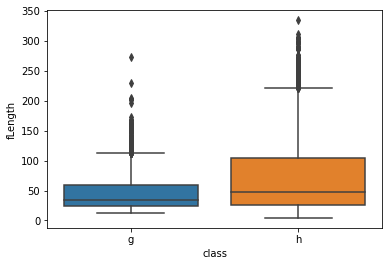

In [ ]:
#@title
sns.boxplot(y=df['fLength'], x = df['class'])

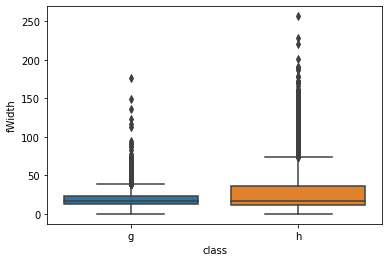

In [ ]:
#@title
sns.boxplot(y=df['fWidth'], x = df['class'])

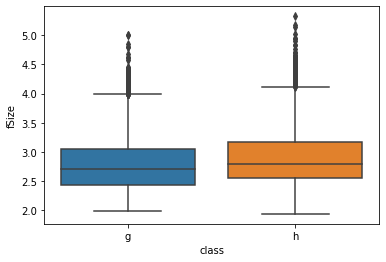

In [ ]:
#@title
sns.boxplot(y=df['fSize'], x = df['class'])

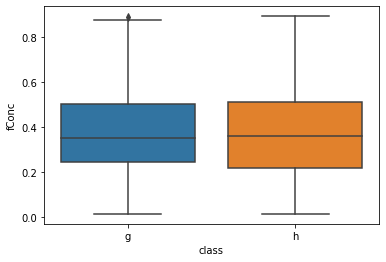

In [ ]:
#@title
sns.boxplot(y=df['fConc'], x = df['class'])

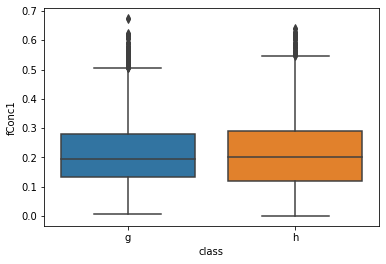

In [ ]:
#@title
sns.boxplot(y=df['fConc1'], x = df['class'])

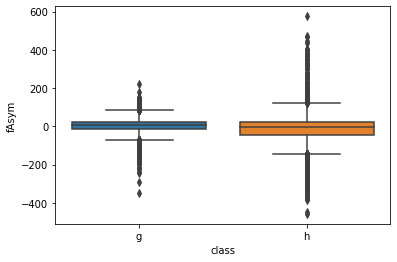

In [ ]:
#@title
sns.boxplot(y=df['fAsym'], x = df['class'])

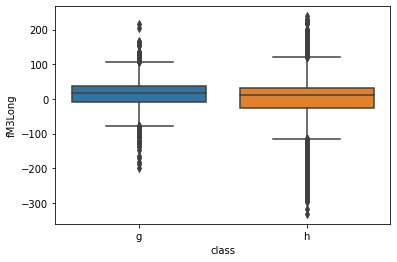

In [ ]:
#@title
sns.boxplot(y=df['fM3Long'], x = df['class'])

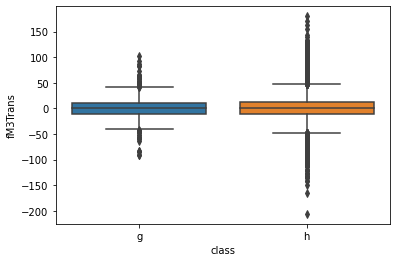

In [ ]:
#@title
sns.boxplot(y=df['fM3Trans'], x = df['class'])

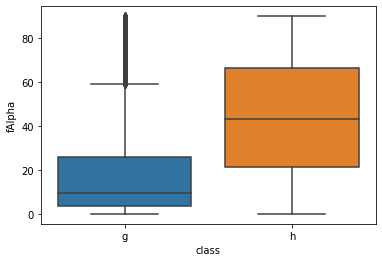

In [ ]:
#@title
sns.boxplot(y=df['fAlpha'], x = df['class'])

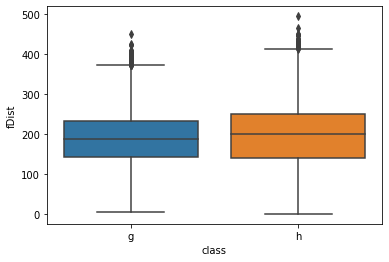

In [ ]:
#@title
sns.boxplot(y=df['fDist'], x = df['class'])

It can be noticed, for example, that there is a significant difference in the fAlpha and a slight difference in the fLength while the other boxplots are very similar.

### Features correlation

$y=x^2$

$e^{i\pi} + 1 = 0$

$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$

$\frac{n!}{k!(n-k)!} = {n \choose k}$

Correlation is a term that is a measure of the strength of a linear relationship between two quantitative variables. <br>
The most familiar measure of dependence between two quantities is the **Pearson product-moment correlation coefficient (PPMCC)**, or "Pearson's correlation coefficient", commonly called simply "**the correlation coefficient**". <br>

A Pearson product-moment correlation coefficient attempts to establish a line of best fit through a dataset of two variables by essentially laying out the expected values and the resulting Pearson's correlation coefficient indicates how far away the actual dataset is from the expected values. Depending on the sign of our Pearson's correlation coefficient, we can end up with either a negative or positive correlation if there is any sort of relationship between the variables of our data set.

The population correlation coefficient between two random variables X and Y with expected values $\mu _{X}$ and $\mu _{Y}$ and standard deviations $\sigma_X$ and $\sigma_Y$ is defined as: <br><br>
$\rho_{X,Y}$ = $corr(X,Y)$ = $\frac{cov(X,Y)}{\sigma_X\sigma_Y}$ = $\frac{E[(X -\mu_X)(Y-\mu_Y)]}{\sigma_X\sigma_Y}$



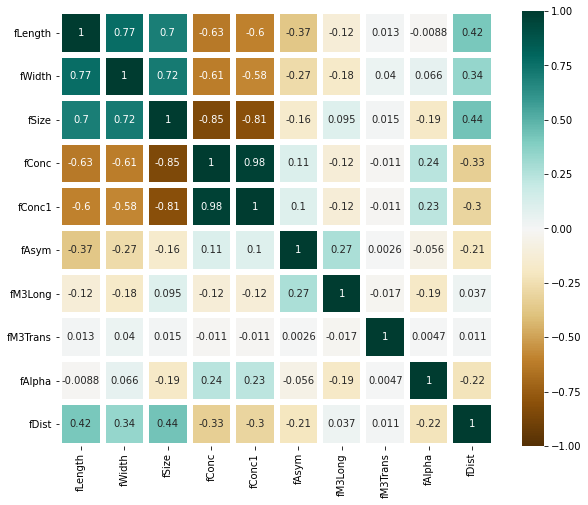

In [ ]:
#@title
x = df.drop(['class'], axis=1)
plt.figure(figsize=(10,8))
sns.heatmap(x.corr(),annot=True,square=True,center=0,vmin=-1,vmax=1,
            cmap='BrBG',linewidths=5)

We can deduce some useful information: the correlation coefficients between the variables *fLength*-*fWidth* and *fWidth*-*fSize* are respectively 0.77 and 0.72. This is the case of positive correlation, between *fLength*-*fWidth* and *fWidth*-*fSize* there is an increasing linear relationships: if one increase the other increase too. On the other hand, between *fConc* and *fSize* we have a negative correlation: if one increase the other decrease and viceversa.

### Pairplot


A pair plot allows us to see both distribution of single variables, in the diagonal, and relationships between two variables.

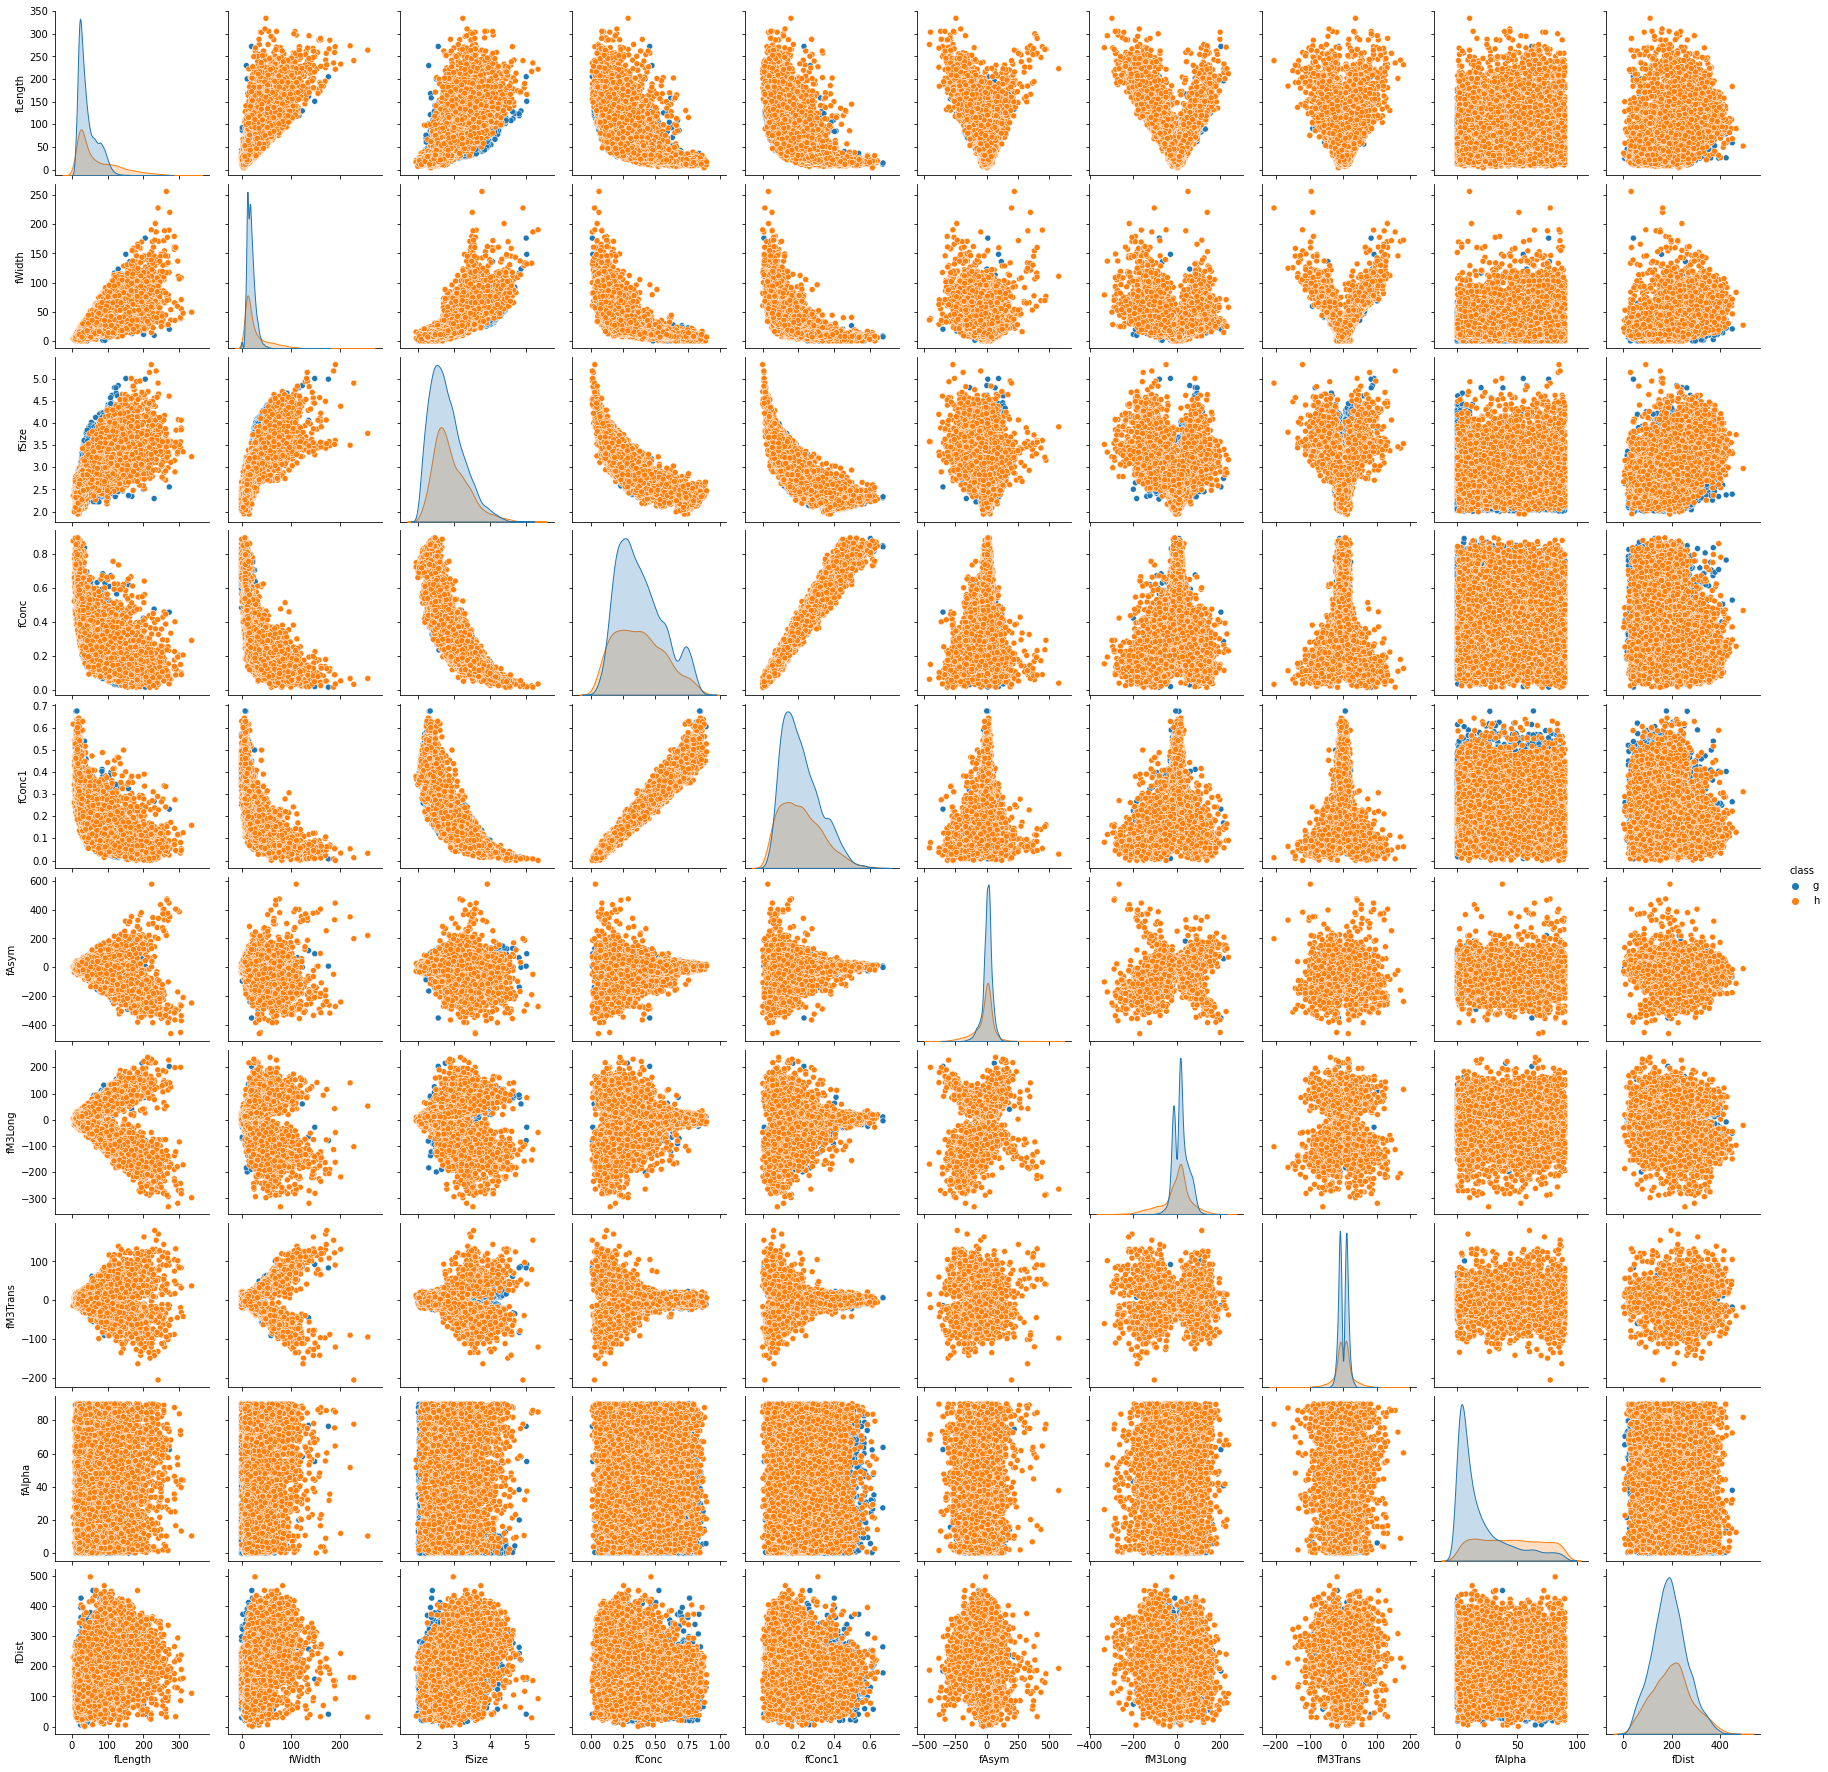

In [ ]:
#@title
sns.pairplot(df, hue = 'class')

## Data preprocessing

### Label encoder

Machine learning alghoritm work only with numerical features so the first step is to encode target labels with value between 0 and n_classes-1. Since we are in a binary problem we have only two classes, we encode:


*   class g: 0
*   class h: 1



In [ ]:
#@title

x = df.drop(['class'], axis=1)
y = df['class']
# h-> 1 
# g-> 0
le = LabelEncoder()
y = le.fit_transform(y)

### StandardScaler

The goal of standardization is to change the values of the variables in order to use a common scale, while preserving differences in each value range. We standardize the data such that each feature has mean equal to 0 and variance equal to 1. This is done such that each feature will equally contribute when using a machine learning algorithm. For example, for models based on distance metrics (e.g. KNN, SVM), if one feature has a larger values range, such feature would dominate much more in the distance computation, and we don't want that.<br><br>
Moreover standardization has to be done especially if we want to apply PCA. PCA projects the original data onto the directions which maximize the variance, so if we don't standardize, PCA would interpret a feature to have more variance just because of its bigger scale. So it will erroneously proceed by projecting the data onto that direction. Conversely, by standardizing, all features would have the same variance, and so they would have the same weight for the principal components calculation.
<br><br>
Then we split the dataset into training and test sets, representing respectively 80% and 20% of the entire data. This is done for not overfitting the model, since the test is performed on a different set.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
scaler = StandardScaler()
x_train, x_test = scaler.fit_transform(x_train), scaler.transform(x_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


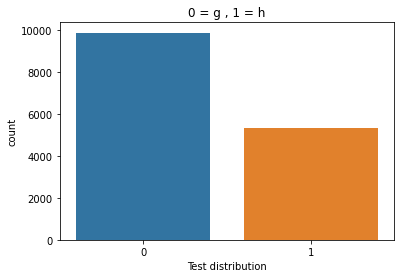

In [ ]:
import seaborn as sns
sns.countplot(y_train, data=df)
plt.title('0 = g , 1 = h')
plt.xlabel('Test distribution')
plt.show()
# in the test we have 2457 class g and 1347 class h

## Model evaluation

In order to evaluate the different models and tune their parameters, **k-fold with stratify** has been used. The entire dataset is divided in k parts and at each iteration one subsample is used as validation set while the remaining parts are used as training set. This process is repeated k times. 

Since we want training and test to have similar distributions, we use stratify to maintain the proportions of the data, considering the binary classification.

Then the final score of the k-fold cross validation procedure is obtained from the average of the k models individual scores. This gives us an idea about how well the model will perform on average, and what are its overall generalization capabilities when applied to different test sets.

Last but foremost, CV is also used for finding the best model hyper-parameters (hyper-parameters tuning): the hyper-parameter values (taken from a selected list) giving the highest CV score are chosen for the final model, whose final evaluation is then assessed on the test set. This overall procedure is called Grid Search Cross Validation.
<br><br><br>
<img width="460" height="300" src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png">
  <center>Stratified K-fold</center>
</p>

We choose to k=5 as it was experimentally proved that this value leads to better results.

## Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test,y_pred)

0.7931125131440588

## Decision Tree

A decision tree is a predictor , h : X $\to$ Y, that predicts the label associated with an instance **x** by traveling from a root node of a tree to a leaf. At each node on the root-to-leaf path, the successor child is chosen on the basis of a splitting of the input space. Usually the splitting is based on one of the features of **x**. A leaf contains a specific label.

In training phase, unfortunately, since it is computationally infeasible to consider every possible partition of the feature space, decision tree learning algorithms are based on heuristics such as a greedy approach, where the three is constructed gradually, and locally optimal decisions are made at the construction of each node.
The algorithm at each step chooses the best predictor to split according to some criteria. The most commons ones are:



1. **Gini Index**:  $1-\sum_{i=1}^{n} p_i^2 $

2. **Cross Entropy**: $\sum_{i=1}^{n} -p_ilog_2p_i$ <br>


$p_i$ is the probability of an object being classified to a particular class. <br><br>


Advantages of a decision tree: <br>
*   Easy to understand: decision trees are very easy to read and interpret, in  fact they do not require any statistical knowledge and its graphical representation is very intuitive;
*   useful in Data Exploration: it is very easy to identify most significant variables and the relation between them.
*   number of hyper-parameters to be tuned is low.
<br><br>

Disadvantages of a decision tree: <br>
*   Over-fitting: decision trees may not generalize the data well due to over-complex trees. This issue can be solved by introducing some constraints and pruning;



In [ ]:
#@title
"""FARE GRID SEARCH CON CROSS VALIDATION"""
model = DecisionTreeClassifier(max_depth=3)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(f'Accuracy decision tree: {accuracy_score(y_test,y_pred)}')

Accuracy decision tree: 0.7807570977917981


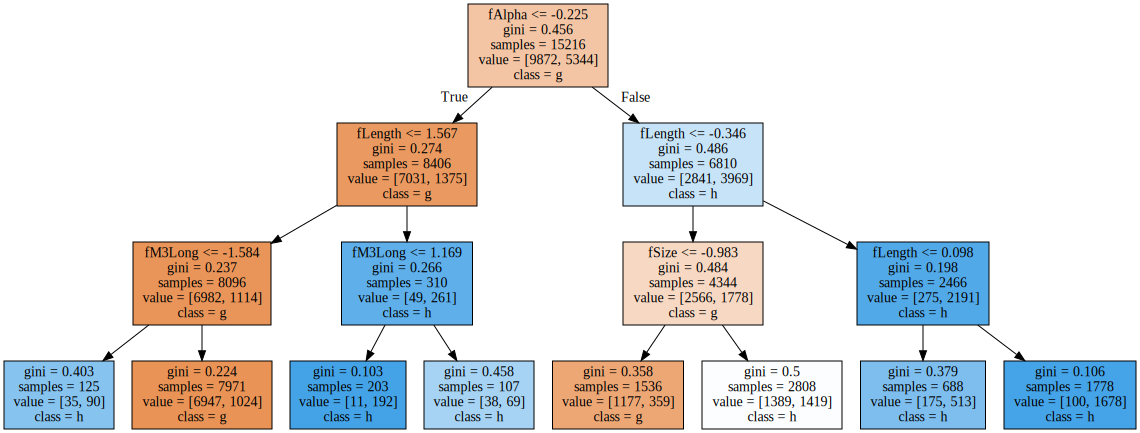

In [ ]:
#@title

# DOT data
feature_columns = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist"] 
class_names = ["g","h"]
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=feature_columns,  
                                class_names=class_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

## Random Forest

In [ ]:
model = RandomForestClassifier()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test,y_pred)

0.879863301787592

## SVM

In [ ]:
model = LinearSVC()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
accuracy_score(y_test,y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7894321766561514